# Group 5 - DBSCAN exploration

We picked the animals dataset because, having previously used it for k-means clustering, we knew it would lend itself well to DBScan clutering as well.
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
penguins = pd.read_csv('2021-11-ml-09-k-means-animals-dataset.csv')

In [3]:
penguins.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN,Not enough blood for isotopes.
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454,NaN
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302,NaN
3,Anvers,"Adult, 1 Egg Stage",N2A2,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426,NaN


Our cleaning steps were:
- Renaming the columns to remove spacing. This made calling these columns more manageable, going forwards.
- Removing all categorical columns. We did this because DBScan can only work with numeric data.
- Dropping rows with more than 50% missing values.
- Imputing missing observations with the mean of the columns.
- Scaling the features using column Z-Scores. We did this because dbscan is sensitive to variance in the data. 

In [4]:
penguins.rename(columns={'Individual ID':'IndividualID','Culmen Length (mm)':'CulmenLength','Culmen Depth (mm)':'CulmenDepth','Flipper Length (mm)':'FlipperLength','Body Mass (g)':'BodyMass','Delta 15 N (o/oo)':'Delta15N','Delta 13 C (o/oo)':'Delta13C'}, inplace=True)  
penguins.drop(['Region','Stage','IndividualID','Comments'], axis=1, inplace=True)
penguins.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Delta15N,Delta13C
count,342.000000,342.000000,342.000000,342.000000,330.000000,331.000000
mean,43.921930,17.151170,200.915205,4201.754386,8.733382,-25.686292
std,5.459584,1.974793,14.061714,801.954536,0.551770,0.793961
min,32.100000,13.100000,172.000000,2700.000000,7.632200,-27.018540
25%,39.225000,15.600000,190.000000,3550.000000,8.299890,-26.320305
50%,44.450000,17.300000,197.000000,4050.000000,8.652405,-25.833520
75%,48.500000,18.700000,213.000000,4750.000000,9.172123,-25.062050
max,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.787670


In [5]:
penguins.dropna(axis=0, thresh=4, inplace=True)
impute_mean = SimpleImputer(strategy='mean')
penguins2 = pd.DataFrame(impute_mean.fit_transform(penguins))
penguins2.columns = penguins.columns
penguins=penguins2

In [6]:
penguins.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Delta15N,Delta13C
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386,8.733382,-25.686292
std,5.459584,1.974793,14.061714,801.954536,0.541975,0.781050
min,32.100000,13.100000,172.000000,2700.000000,7.632200,-27.018540
25%,39.225000,15.600000,190.000000,3550.000000,8.305905,-26.295280
50%,44.450000,17.300000,197.000000,4050.000000,8.681410,-25.795390
75%,48.500000,18.700000,213.000000,4750.000000,9.141270,-25.081043
max,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.787670


In [7]:
ss = StandardScaler()
z_penguins = ss.fit_transform(penguins)
z_penguins = pd.DataFrame(z_penguins, columns=penguins.columns.tolist())

In [8]:
z_penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Delta15N       342 non-null    float64
 5   Delta13C       342 non-null    float64
dtypes: float64(6)
memory usage: 16.2 KB


## DBSCAN
### Pre-optimization

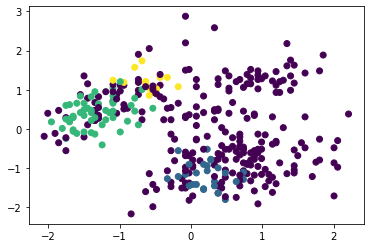

In [9]:
db = DBSCAN(eps=.8,min_samples=12).fit(z_penguins)
plt.scatter(z_penguins['CulmenDepth'],z_penguins['CulmenLength'], c=db.labels_)

### K-Distance Graph

In order to find the best epsilon value, we created a K-Distance graph and located the point of maximum curvature on the Y-Axis.

Based on the graph, 1.0 is likely a reasonable value for epsiolon in the DBScan.

In [10]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(z_penguins)
distances, indices = nbrs.kneighbors(z_penguins)

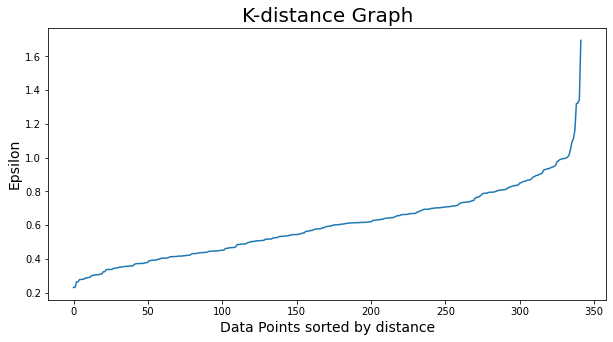

In [11]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

### Silhouette score

In order to find the best value for minPts, we tested a range of values on the DBScan model and examined the model's silhouette value.

A silhouette value measures the strength of individual clusters from a scale of -1 to 1. If the value is close to 0, this indicates issues of overlapping values.

We then graphed the silhouette and minPts values. Based on the graph, it would seem a minPts value of 8 would be optimal.

In [12]:
silhouettes = []
for mins in range(1,31):
    dbscan = DBSCAN(eps=1,min_samples=mins).fit(z_penguins)
    labels = dbscan.labels_
    silhouettes.append(metrics.silhouette_score(z_penguins, labels))

In [13]:
silhouettes

[-0.040026330918482685,
 0.09934648619937088,
 0.1607493079910759,
 0.30237606387262406,
 0.31787900269748764,
 0.31035794576750325,
 0.29335771895275564,
 0.3690620876599879,
 0.36197865637648713,
 0.341782627736841,
 0.33254938245088234,
 0.3276766784454928,
 0.3043852742088732,
 0.29318323917436456,
 0.27553911494874445,
 0.24953378349432626,
 0.18977723607771285,
 0.12861258587536437,
 0.13475957708480593,
 0.0804305382739311,
 0.12086070111342345,
 0.10182862527314687,
 0.10182862527314687,
 0.08598204441120647,
 0.03756007767739538,
 0.016828111690632995,
 -0.01260159950480895,
 -0.055961571082926376,
 -0.1362024308545424,
 0.08007374704700702]

Text(0, 0.5, 'Silhouette Score')

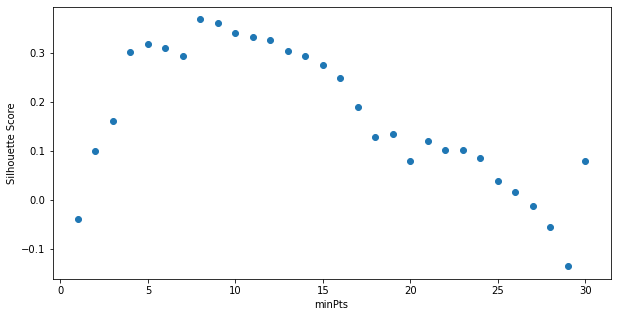

In [14]:
mins = range(1,31)
plt.figure(figsize=(10,5))
plt.scatter(x=mins, y=silhouettes)
plt.xlabel('minPts')
plt.ylabel('Silhouette Score')

Here is the DBScan model so far.

In [15]:
dbscan = DBSCAN(eps=1,min_samples=8).fit(z_penguins)
df_result = pd.DataFrame(dbscan.labels_)
print(df_result.value_counts())

 0    121
 2    118
 1     66
-1     37
dtype: int64


Plotting all combinations of columns and its clusters.

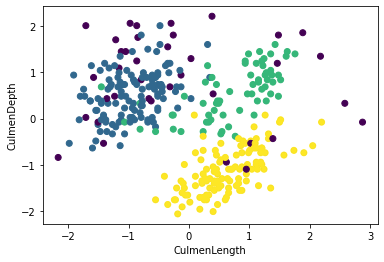

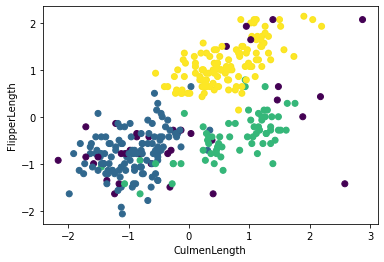

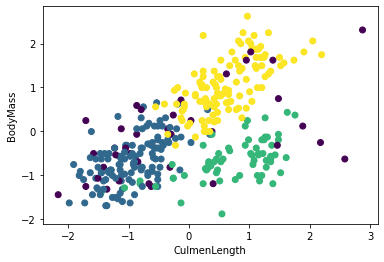

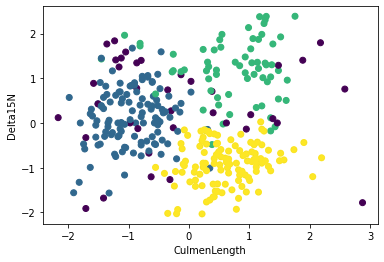

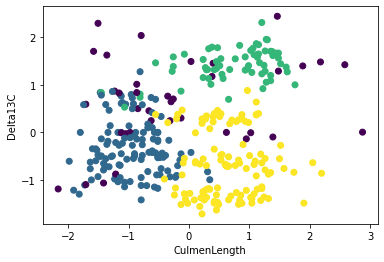

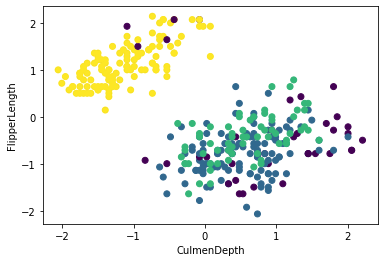

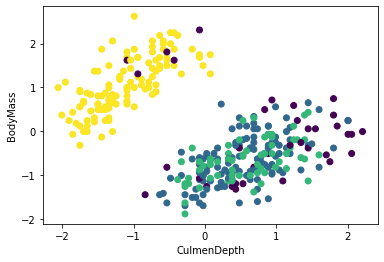

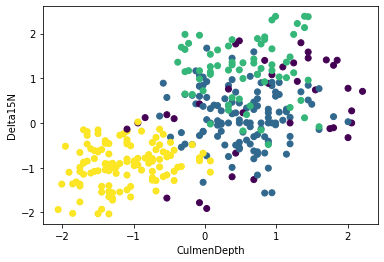

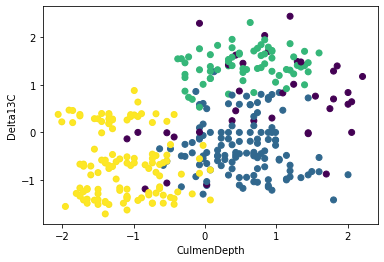

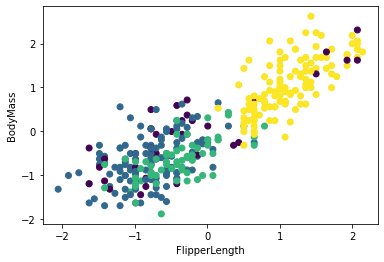

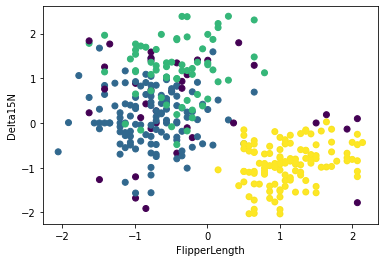

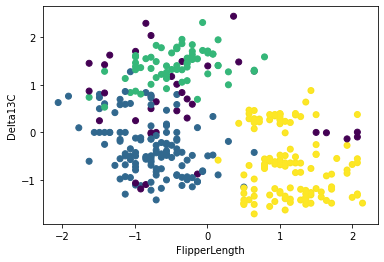

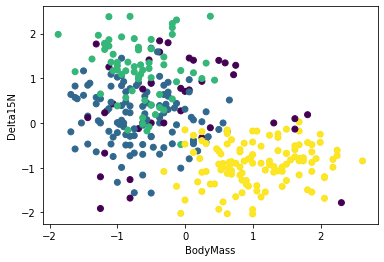

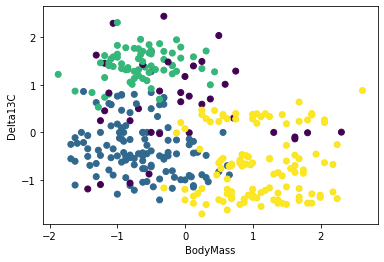

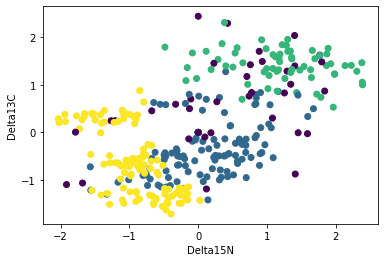

In [16]:
already_x = []
count = 0
for x in z_penguins.columns:
    for y in z_penguins.columns:
        if (x != y) & (y not in already_x): 
            already_x.append(x)
            z_penguins.plot(kind="scatter",x=x, y=y,c=dbscan.labels_);   
            plt.scatter(z_penguins[x], z_penguins[y], c=dbscan.labels_);

## KMEANS

We implementing a simple kmeans clustering model to compare our DBScan to. 


We built a K-means elbow graph to find the ideal number of clusters.

H:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


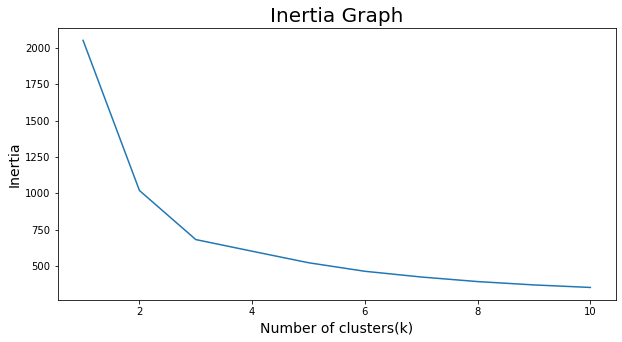

In [38]:
ssd = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(z_penguins)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1,11),ssd)
plt.title('Inertia Graph',fontsize=20)
plt.xlabel('Number of clusters(k)',fontsize=14)
plt.ylabel('Inertia',fontsize=14)
plt.show()

A K-means with 3 clusters seemed most appropriate, based on the elbow graph.

0    143
1    123
2     76
dtype: int64


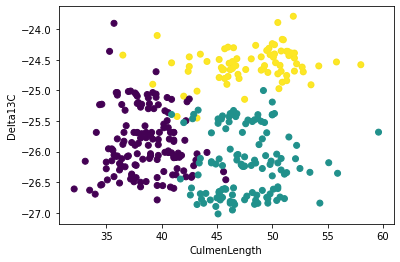

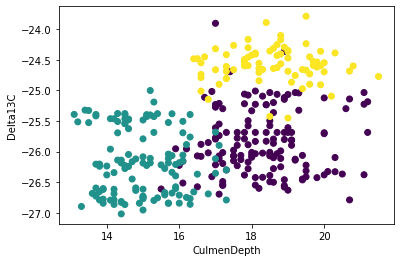

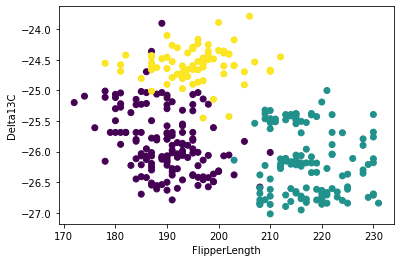

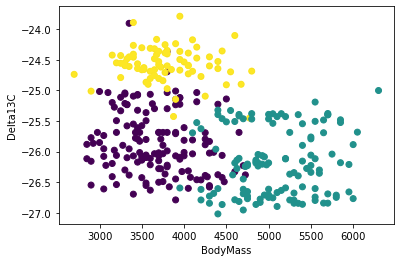

In [18]:
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=0 )

y_kmeans = kmeans.fit_predict(z_penguins)

print(pd.DataFrame(y_kmeans).value_counts())

for i in penguins.columns[:4]:
    y="Delta13C"
    penguins.plot(kind="scatter",x=i, y=y,c=y_kmeans);   
    plt.scatter(penguins[i], penguins[y], c=y_kmeans);

### Dimensionality Reduction Tests

#### Using Silhouette Score

After having made a basic DBScan model with tuned hyperparameters, we wanted to further test the model.
While silhouette-scores are good at measuring the strength of clusters in a classification model,
they can be less accurate when used on data that is in many dimensions.

In order to ammend this, we re-assesed our model using a method borrowed from tushar-joshi-89.medium.com.
We falsely understood this method to be a way of further improving the accuracy of the Silhouette score. In the end, it generated a value based on false presumptions.
With this method, we created a new column for our dataframe that calculated each row's raw-distance from the center of the plot.
By creating a silhouette score using this 'Z' row and the DBScan's labels, we hoped to reduce the issue of dimensionality in the silhouette-score.

In [19]:
z_penguins['Z'] = z_penguins.apply(lambda row: np.linalg.norm([0,0,0,0,0,0] - row[[0,1,2,3,4,5]]), axis=1)
metrics.silhouette_score(z_penguins[['Z']], dbscan.labels_)

0.019289640843070575

The silhouette score was very close to zero, indicating overlap in our DBScan model's clusters

In [20]:
i = [(0,1),(0,2),(0,3),(0,4),(0,5),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]

To examine this issue in the data, we referred back to the graphs of our DBScan on every column combination.

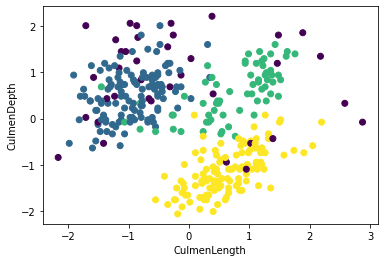

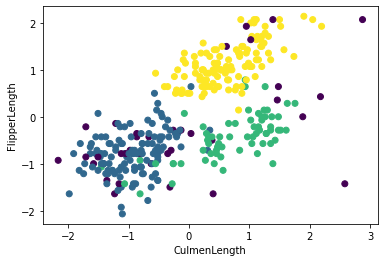

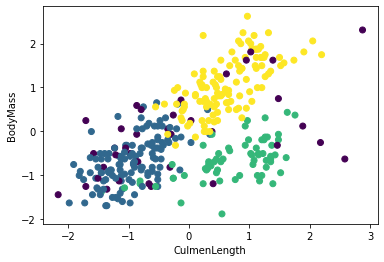

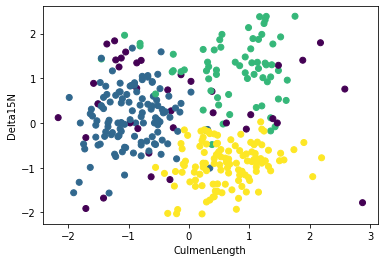

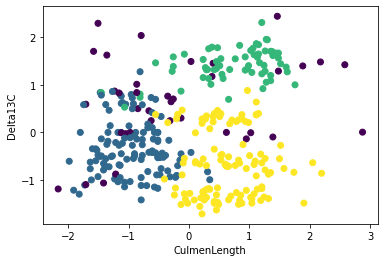

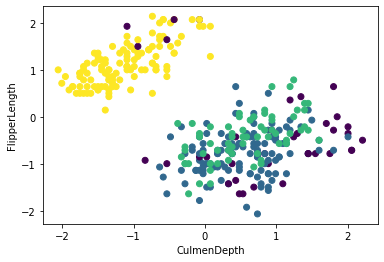

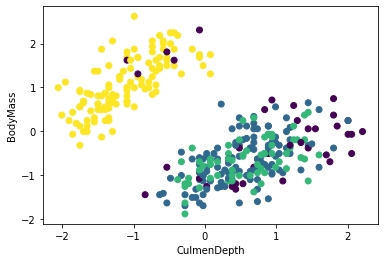

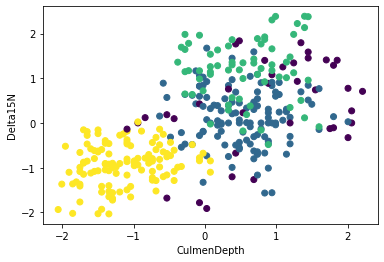

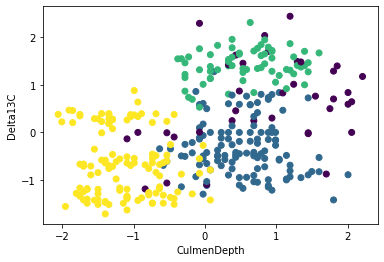

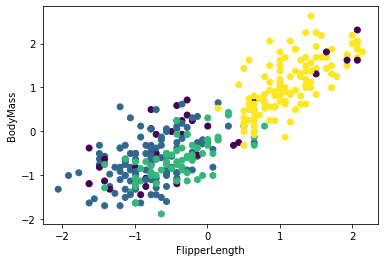

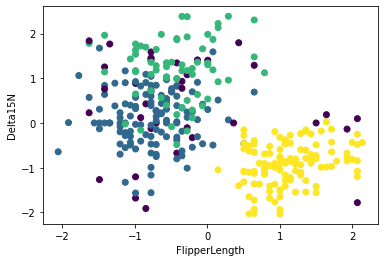

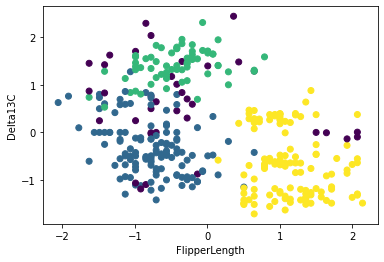

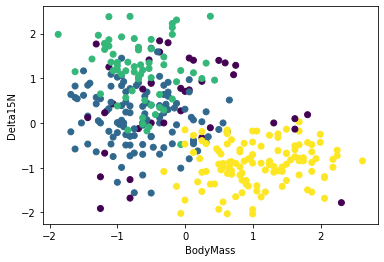

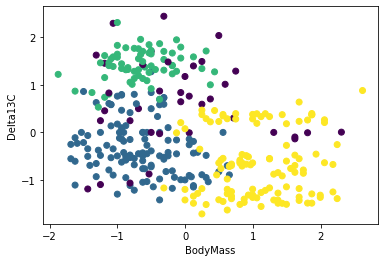

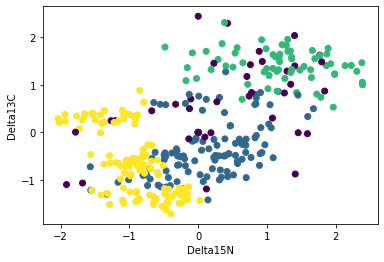

In [21]:
for tupl in range(0,len(i)):
    plt.scatter(z_penguins[z_penguins.columns[i[tupl][0]]], z_penguins[z_penguins.columns[i[tupl][1]]], c=dbscan.labels_)
    plt.xlabel(z_penguins.columns[i[tupl][0]])
    plt.ylabel(z_penguins.columns[i[tupl][1]])
    plt.show()    

While the clusters frequently occupied distinct domains, there were several variable combinations where two clusters overlaped.
This was likely the reason for the low silhouette score.

We next attempted to reduce the dimensionality of dataset in order to see if the distance based silouette score could be improved using the method from tushar-joshi-89.medium.com.

In [22]:
z_filtered = z_penguins.copy()
z_filtered.drop(columns=['BodyMass','Z'], axis=1, inplace=True)
dbscan2 = DBSCAN(eps=1,min_samples=8).fit(z_filtered)
z_filtered['Z'] = z_filtered.apply(lambda row: np.linalg.norm([0,0,0,0,0] - row[list(z_filtered.columns)]), axis=1)
metrics.silhouette_score(z_filtered[['Z']], dbscan2.labels_)

-0.008943505331688103

In [23]:
z_filtered = z_penguins.copy()
z_filtered.drop(columns=['BodyMass','FlipperLength','Z'], axis=1, inplace=True)
dbscan2 = DBSCAN(eps=1,min_samples=8).fit(z_filtered)
z_filtered['Z'] = z_filtered.apply(lambda row: np.linalg.norm([0,0,0,0] - row[list(z_filtered.columns)]), axis=1)
metrics.silhouette_score(z_filtered[['Z']], dbscan2.labels_)

-0.08419131677891914

In [24]:
z_filtered = z_penguins.copy()
z_filtered.drop(columns=['BodyMass','CulmenDepth','FlipperLength','Z'], axis=1, inplace=True)
dbscan2 = DBSCAN(eps=1,min_samples=8).fit(z_filtered)
z_filtered['Z'] = z_filtered.apply(lambda row: np.linalg.norm([0,0,0] - row[list(z_filtered.columns)]), axis=1)
metrics.silhouette_score(z_filtered[['Z']], dbscan2.labels_)

0.5007051515698054

In [25]:
z_filtered.columns

Index(['CulmenLength', 'Delta15N', 'Delta13C', 'Z'], dtype='object')

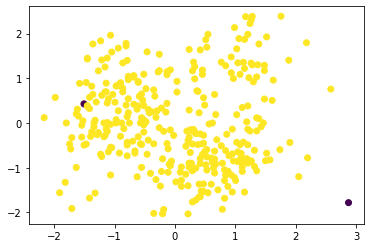

In [26]:
plt.scatter(z_filtered['CulmenLength'], z_filtered['Delta15N'], c=dbscan2.labels_)

After reducing our columns by three, we were able to achieve a distance-based Silouette score of 0.5, theoretically a marked improvement.
However the supposed improvement was due to a reduction in the clusters to 1, as well as at the expense of multiple variables of data.
This lead us to conclude that the distance formula hurt, rather then aided, the building of the DBScan model, as it also conflicted with domain knowledge regarding to the dataset; by this point, through research, we had come to learn that the data was observing three distinct species of penguin. Therefore, if we were hoping to classify the data accurately, we would expect three clusters of data, not one.
Rather then yielding a more accurate Silhouette score, the distance based formula produced a score
that was much more senitive to dimensionality, it was not appropriate for this data.

Rather then simply disregard the silhouette scores, we decided to use another method of tuning the hyperparameters
(in addition to, not instead of, the previously fitted silhouette scores).

In [27]:
z_penguins.columns
z_penguins.drop(columns=['Z'], axis=1, inplace=True)

Using the following method, we printed the value-counts for several DBScan labels, each of which tested different min_samples values.

In [28]:
for min_s in range(50):
    print(f'epsilon: 1, min_samples: {min_s}')
    dbscan=DBSCAN(eps=1, min_samples=min_s).fit(z_penguins) 
    df_result = pd.DataFrame(dbscan.labels_)
    print(df_result.value_counts())

epsilon: 1, min_samples: 0
0     205
12    122
1       3
6       2
2       1
3       1
4       1
5       1
7       1
8       1
9       1
10      1
11      1
13      1
dtype: int64
epsilon: 1, min_samples: 1
0     205
12    122
1       3
6       2
2       1
3       1
4       1
5       1
7       1
8       1
9       1
10      1
11      1
13      1
dtype: int64
epsilon: 1, min_samples: 2
 0    205
 3    122
-1     10
 1      3
 2      2
dtype: int64
epsilon: 1, min_samples: 3
 0    205
 2    122
-1     12
 1      3
dtype: int64
epsilon: 1, min_samples: 4
 0    205
 1    122
-1     15
dtype: int64
epsilon: 1, min_samples: 5
 0    201
 1    119
-1     22
dtype: int64
epsilon: 1, min_samples: 6
 0    196
 1    119
-1     27
dtype: int64
epsilon: 1, min_samples: 7
 0    190
 1    119
-1     33
dtype: int64
epsilon: 1, min_samples: 8
 0    121
 2    118
 1     66
-1     37
dtype: int64
epsilon: 1, min_samples: 9
 2    118
 0    115
 1     63
-1     46
dtype: int64
epsilon: 1, min_samples: 10
 2

Due to our domain knowledge, we knew the desired number of clusters was 3.
By finding the min_samples value that both returned 3 clusters and had the least amount of outliers, we were able to find a suitable
min_samples value. And this value was 8, the same value determined using the first silhouette-score method.

Now we have two pieces of evidence that support our hyperparameter tuning.
We can now conclude that our DBScan model is optimized.

#### Using PCA Dimension Reduction

Below is one more attempt at using dimension-reduction to achieve better hyper-parameters.

In [29]:
pca = PCA(n_components=2)
z_penguins_reduced = pca.fit_transform(z_penguins)
z_penguins_reduced = pd.DataFrame(z_penguins_reduced)

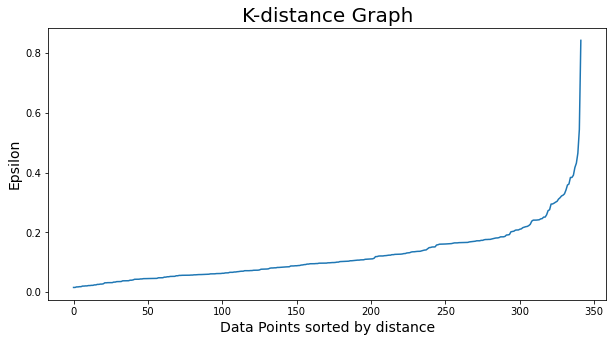

In [30]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(z_penguins_reduced)
distances, indices = nbrs.kneighbors(z_penguins_reduced)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [31]:
silhouettes_red = []
for mins in range(35):
    dbscan = DBSCAN(eps=.37,min_samples=mins).fit(z_penguins_reduced)
    labels = dbscan.labels_
    silhouettes_red.append(metrics.silhouette_score(z_penguins_reduced, labels))

Text(0, 0.5, 'Score')

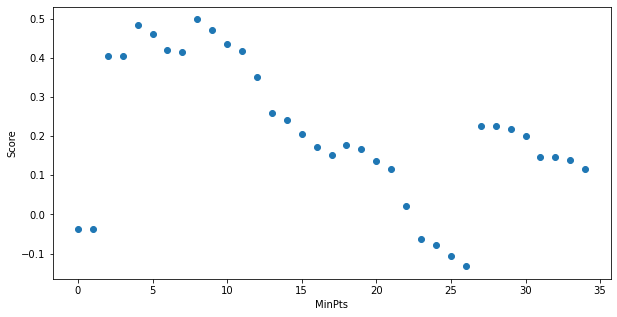

In [32]:
mins = range(35)
plt.figure(figsize=(10,5))
plt.scatter(x=mins, y=silhouettes_red)
plt.xlabel('MinPts')
plt.ylabel('Score')

 0    126
 2    115
 1     54
-1     47
dtype: int64


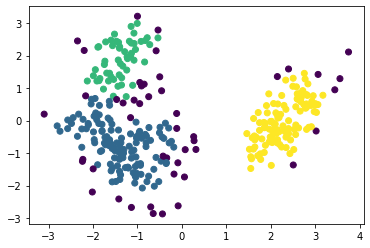

In [33]:
dbscan=DBSCAN(eps=.37, min_samples=9).fit(z_penguins_reduced) 
df_result = pd.DataFrame(dbscan.labels_)

z_penguins_reduced['cluster'] = df_result

z_penguins_reduced

plt.scatter(z_penguins_reduced[0], z_penguins_reduced[1], c=dbscan.labels_)
print(df_result.value_counts())

### Accuracy Scores
Because we have the original dataset with the species y column, we thougtht it would be interesting to compare accuracy scores. We understand that this would not be available in a real world clustering problem, but in a learning environment, this is interesting to look at. We will import the original dataset, strip down to our original numeric columns, drop all missing values which brings our rows to 330, and take out the y column for comparison. 

We will compare the kmeans, the DBSCAN, and DBSCAN on reduced dimensions. 

In [34]:
penguins_df = pd.read_csv('penguindata.csv')
penguins_df= penguins_df[['Species','Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)','Body Mass (g)',\
    'Delta 15 N (o/oo)','Delta 13 C (o/oo)']]
penguins_df = penguins_df.dropna()

X = penguins_df._get_numeric_data().values
y = penguins_df[['Species']]


species = {'Adelie Penguin (Pygoscelis adeliae)': 0, 'Gentoo penguin (Pygoscelis papua)': 1, 'Chinstrap penguin (Pygoscelis antarctica)': 2}
y = [species[item] for item in y['Species']]
y = np.array(y) 

ss = StandardScaler()
X = ss.fit_transform(X) 

#### K-Means accuracy

In [35]:
kmeans = KMeans(n_clusters=3, random_state=0)
kclusters = kmeans.fit_predict(X)
print(accuracy_score(kclusters, y))

0.9757575757575757


#### DBSCAN acccuracy

In [36]:
dbscan = DBSCAN(eps=1,min_samples=8).fit(X)
df_result = dbscan.labels_
print(accuracy_score(df_result, y))

0.33636363636363636


#### DBSCAN reduced dimension accuracy

In [37]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced)
dbscan=DBSCAN(eps=.37, min_samples=9).fit(X_reduced) 
df_result = dbscan.labels_
print(accuracy_score(df_result, y))

0.32727272727272727


As we can tell, the kmeans algorithm did the best with predictions being 97% accurate, which makes sense because we told it there is 3 clusters. It went out grouped the points together with 3 groups that would be most similar to each other.

​With DBSCAN, and even when we reduced the dimensions down to test it, we found that accuracy is around 30%, which also made sense because we never could get the model to recognize three species without any outliers. With the outliers stealing from three of our species, it makes sense that we are left with 30% accuracy. 

### Conclusion

We concluded that this algorithm is not the best for our dataset. DBSCAN is density based, and our theory is that the penguins' species information is too closely similar for this algorithm to effectively determine the differences. Being centroid-based, K-means is better at determining data in hypersphere shapes.